# Figure showcasing the posterior

In [1]:
import os, glob
import numpy as np
from tqdm.notebook import tqdm, trange

In [2]:
import torch
from haloflow import data as D
from haloflow import util as U

In [3]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

In [5]:
qphis0 = U.read_best_ndes('msmh.mags.maf', device=device)
qphis1 = U.read_best_ndes('msmh.mags_morph.maf', device=device)
# qphis2 = U.read_best_ndes('msmh.mags_morph_satlum_all.maf', device=device)
# qphis3 = U.read_best_ndes('msmh.mags_morph_satlum_all_rich_all.maf', device=device)
qphis2 = U.read_best_ndes('msmh.v1.mags_morph_satlum_mrlim.maf', device=device)
qphis3 = U.read_best_ndes('msmh.v1.mags_morph_satlum_mrliml_rich_mrlim.maf', device=device)

1083 models trained
[138, 529, 86, 803, 942]
1669 models trained
[49, 1523, 1159, 1415, 690]
3674 models trained
[1142, 3137, 2836, 1502, 182]
3089 models trained
[1083, 897, 1676, 813, 2716]


In [6]:
y0, x0 = D.get_subhalos('test', 'mags', snapshot=91)
y1, x1 = D.get_subhalos('test', 'mags_morph', snapshot=91)
# y2, x2 = D.get_subhalos('test', 'mags_morph_satlum_all', snapshot=91)
# y3, x3 = D.get_subhalos('test', 'mags_morph_satlum_all_rich_all', snapshot=91)
y2, x2 = D.get_subhalos('test', 'mags_morph_satlum_mrlim', snapshot=91)
y3, x3 = D.get_subhalos('test', 'mags_morph_satlum_mrlim_rich_mrlim', snapshot=91)

In [7]:
n_sample = 10000

ranks0, ranks1, ranks2, ranks3 = [], [], [], []
y_nde0, y_nde1, y_nde2, y_nde3 = [], [], [], []

for i in trange(y0.shape[0]): 
    for qphis, ranks, y_nde, xs, ys in zip([qphis0, qphis1, qphis2, qphis3], 
                                           [ranks0, ranks1, ranks2, ranks3], 
                                           [y_nde0, y_nde1, y_nde2, y_nde3], 
                                           [x0, x1, x2, x3], [y0, y1, y2, y3]): 
        y_samp = []
        for qphi in qphis: 
            _samp = qphi.sample((int(n_sample/len(qphis0)),),
                               x=torch.tensor(xs[i], dtype=torch.float32).to(device), 
                               show_progress_bars=False)
            y_samp.append(_samp.detach().cpu().numpy())
        y_nde.append(np.concatenate(np.array(y_samp), axis=0))        
    
        _ranks = []
        for i_dim in range(y_nde[-1].shape[1]): 
            _ranks.append(np.mean(y_nde[-1][:,i_dim].flatten() < ys[i, i_dim]))
        ranks.append(_ranks)
    
ranks0 = np.array(ranks0)
ranks1 = np.array(ranks1)
ranks2 = np.array(ranks2)
ranks3 = np.array(ranks3)

y_nde0 = np.array(y_nde0)
y_nde1 = np.array(y_nde1)
y_nde2 = np.array(y_nde2)
y_nde3 = np.array(y_nde3)

  0%|          | 0/500 [00:00<?, ?it/s]

In [30]:
i_field = 439 # np.random.choice(np.arange(x3.shape[0])[x3[:,-1] == 0])
i_group = 16 # np.random.choice(np.arange(x3.shape[0])[x3[:,-1] > 5])

In [42]:
print('Field: log M* = %.2f, log Mh = %.2f' % (y0[i_field][0], y0[i_field][1]))
print('Group: log M* = %.2f, log Mh = %.2f' % (y0[i_group][0], y0[i_group][1]))

Field: log M* = 9.78, log Mh = 11.27
Group: log M* = 11.04, log Mh = 12.41


In [32]:
print('Group galaxy has %i satellites' % x3[i_group, -1])

Group galaxy has 7 satellites


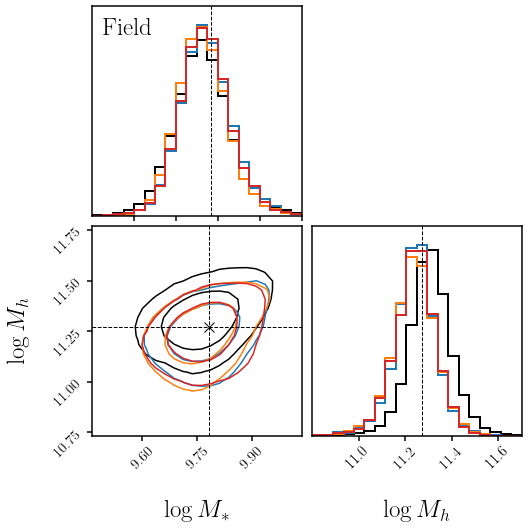

In [33]:
fig = plt.figure(figsize=(8,8))

rng = [(9.5, 10.0), (10.8, 11.7)]
_ = DFM.corner(y_nde0[i_field], color='k', range=rng, 
                 hist_kwargs={'density': True, 'linewidth': 2},
                 levels=[0.68, 0.95], plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
_ = DFM.corner(y_nde1[i_field], color='C0', range=rng, hist_kwargs={'density': True, 'linewidth': 2},
               levels=[0.68, 0.95], plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
_ = DFM.corner(y_nde2[i_field], color='C1', range=rng, hist_kwargs={'density': True, 'linewidth': 2},
               levels=[0.68, 0.95], plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
_ = DFM.corner(y_nde3[i_field], color='C3', range=rng, hist_kwargs={'density': True, 'linewidth': 2},
               levels=[0.68, 0.95], 
               labels=[r'$\log M_*$', r'$\log M_h$'], label_kwargs={'fontsize': 25},
                plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
DFM.overplot_points(fig, [y0[i_field]], color='k', marker='x', markersize=10)
DFM.overplot_lines(fig, y0[i_field], color='k', linestyle='--', linewidth=1)

axes = np.array(fig.axes).reshape(2,2)


sub = axes[0,0]
sub.text(0.05, 0.95, 'Field', transform=sub.transAxes, ha='left', va='top', fontsize=25)

sub = axes[1,1]
sub.set_xlim(rng[1])

sub = axes[0,0]
sub.set_xlim(rng[0])
fig.savefig('figs/posterior_field.pdf', bbox_inches='tight')

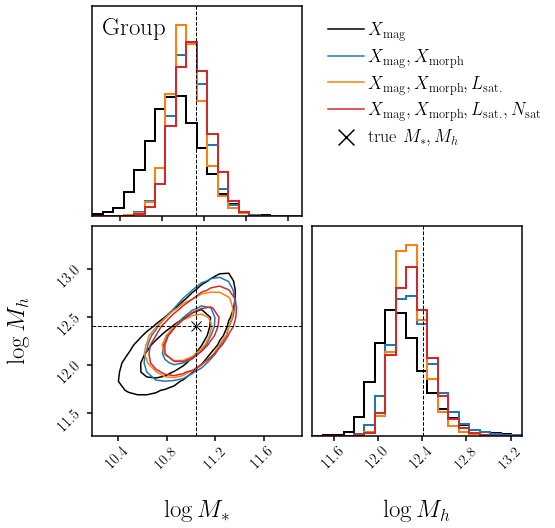

In [41]:
fig = plt.figure(figsize=(8,8))

rng = [(10.3, 11.8), (11.4, 13.3)]
_ = DFM.corner(y_nde0[i_group], color='k', range=rng, 
                 hist_kwargs={'density': True, 'linewidth': 2},
                 levels=[0.68, 0.95], plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
_ = DFM.corner(y_nde1[i_group], color='C0', range=rng, hist_kwargs={'density': True, 'linewidth': 2},
               levels=[0.68, 0.95], plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
_ = DFM.corner(y_nde2[i_group], color='C1', range=rng, hist_kwargs={'density': True, 'linewidth': 2},
               levels=[0.68, 0.95], plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
_ = DFM.corner(y_nde3[i_group], color='C3', range=rng, hist_kwargs={'density': True, 'linewidth': 2},
               levels=[0.68, 0.95], 
               labels=[r'$\log M_*$', r'$\log M_h$'], label_kwargs={'fontsize': 25},
                plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
DFM.overplot_points(fig, [y0[i_group]], color='k', marker='x', markersize=10)
DFM.overplot_lines(fig, y0[i_group], color='k', linestyle='--', linewidth=1)

axes = np.array(fig.axes).reshape(2,2)

sub = axes[0,0]
sub.text(0.05, 0.95, 'Group', transform=sub.transAxes, ha='left', va='top', fontsize=25)

sub = axes[0,1]
sub.plot([], [], color='k', label=r'$X_{\rm mag}$')
sub.plot([], [], color='C0', label=r'$X_{\rm mag}, X_{\rm morph}$')
sub.plot([], [], color='C1', label=r'$X_{\rm mag}, X_{\rm morph}, L_{\rm sat.}$')
sub.plot([], [], color='C3', label=r'$X_{\rm mag}, X_{\rm morph}, L_{\rm sat.}, N_{\rm sat}$')
sub.scatter([], [], color='k', marker='x', s=10, label='true $M_*, M_h$')
sub.legend(loc='upper left', handletextpad=0.2, markerscale=5, fontsize=18)

sub = axes[1,1]
sub.set_xlim(rng[1])


sub = axes[0,0]
sub.set_xlim(rng[0])
fig.savefig('figs/posterior_group.pdf', bbox_inches='tight')

# comparison to state-of-the-art

https://arxiv.org/pdf/0903.4682.pdf

In [18]:
tng_ms, tng_mh_mean, tng_mh_sig = np.loadtxt('/scratch/gpfs/chhahn/haloflow/tng.ms_mh.txt', 
                                                      skiprows=1, unpack=True)

In [19]:
tng_mh_sig

array([0.30507312, 0.15184572, 0.17302857, 0.1321713 , 0.15481852,
       0.11899736, 0.10597655, 0.10441712, 0.11397482, 0.10125167,
       0.09677312, 0.11157713, 0.09229181, 0.11131102, 0.10914812,
       0.13630185, 0.24889404, 0.24154646, 0.09307589, 0.15682888])

In [20]:
tng_mh_mean.max()

13.296007443869108

In [22]:
Mh = np.random.uniform(11, 13.2, 10000)
Ms = np.interp(Mh, tng_mh_mean, tng_ms)
Ms[Mh > 12.] += 0.15 * np.random.normal(size=np.sum(Mh > 12.))
Ms[Mh < 12.] += (0.15 + 0.15 * (12.-Mh[Mh < 12.]))* np.random.normal(size=np.sum(Mh < 12.))

In [23]:
ms_bins = np.linspace(10., 11., 11)

mh_std = []
for i in range(len(ms_bins)-1): 
    in_ms = (Ms > ms_bins[i]) & (Ms <= ms_bins[i+1])
    mh_std.append(np.std(Mh[in_ms]))

In [24]:
mh_std

[0.14346200201115522,
 0.1527691920907686,
 0.15954491732030932,
 0.15671171007058438,
 0.16218065963481246,
 0.1598511074544154,
 0.1563413581283018,
 0.14937534706678196,
 0.16279985010426634,
 0.17562333087661677]

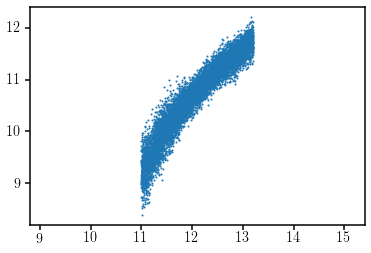

In [25]:
plt.scatter(Mh, Ms, s=1)

In [26]:
def logmh_tng(logms): 
    '''sample mh given the M_*-M_h relation of TNG
    '''
    mu_logms = np.interp(logms, tng_ms, tng_mh_mean)
    sig_logms = 0.15 #np.interp(logms, tng_ms, tng_mh_sig)
    
    return mu_logms + sig_logms * np.random.normal(size=len(logms))

In [27]:
mcmc_mh_tng = logmh_tng(y_nde0[i_group,:,0])
mcmc_straw = np.array([y_nde0[i_group,:,0], np.array(mcmc_mh_tng)]).T

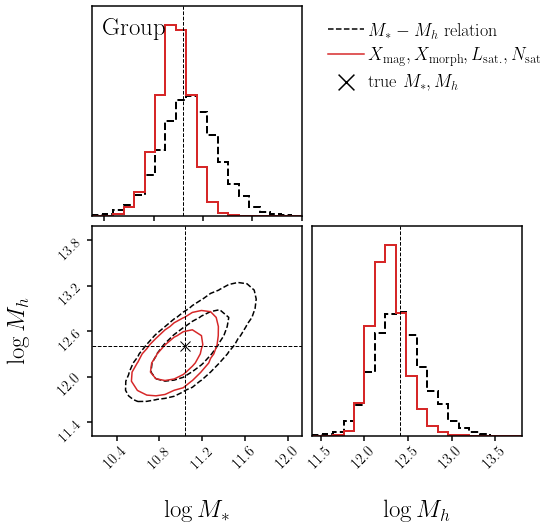

In [17]:
fig = plt.figure(figsize=(8,8))

rng = [(10.3, 12.0), (11.4, 13.8)]
_ = DFM.corner(mcmc_straw, color='k', range=rng, 
               contour_kwargs={'linestyles': '--'}, 
               contourf_kwargs={'linestyles': '--'},                
               hist_kwargs={'density': True, 'linewidth': 2, 'linestyle':'--'},
               levels=[0.68, 0.95], plot_datapoints=False, plot_density=False, smooth=True, fig=fig)

_ = DFM.corner(y_nde3[i_group], color='C3', range=rng, hist_kwargs={'density': True, 'linewidth': 2},
               levels=[0.68, 0.95], 
               labels=[r'$\log M_*$', r'$\log M_h$'], label_kwargs={'fontsize': 25},
                plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
DFM.overplot_points(fig, [y0[i_group]], color='k', marker='x', markersize=10)
DFM.overplot_lines(fig, y0[i_group], color='k', linestyle='--', linewidth=1)

axes = np.array(fig.axes).reshape(2,2)

sub = axes[0,0]
sub.text(0.05, 0.95, 'Group', transform=sub.transAxes, ha='left', va='top', fontsize=25)

sub = axes[0,1]
sub.plot([], [], color='k', ls='--', label=r'$M_* - M_h$ relation')
sub.plot([], [], color='C3', label=r'$X_{\rm mag}, X_{\rm morph}, L_{\rm sat.}, N_{\rm sat}$')
sub.scatter([], [], color='k', marker='x', s=10, label='true $M_*, M_h$')
sub.legend(loc='upper left', handletextpad=0.2, markerscale=5, fontsize=18)

sub = axes[1,1]
sub.set_xlim(rng[1])


sub = axes[0,0]
sub.set_xlim(rng[0])
fig.savefig('figs/posterior_group_straw.pdf', bbox_inches='tight')

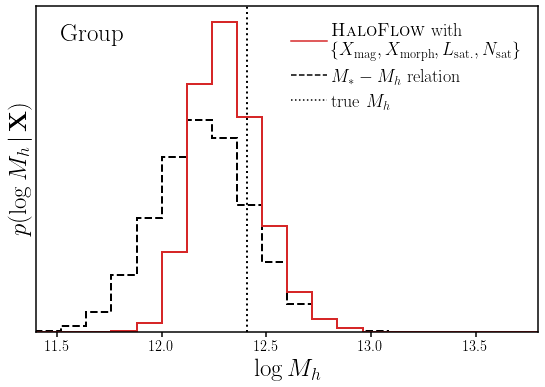

In [29]:
fig = plt.figure(figsize=(9,6))

sub = fig.add_subplot(111)
sub.hist(mcmc_straw[:,1], range=(11.4, 13.8), bins=20, histtype='step', color='k', linestyle='--', linewidth=2)
sub.hist(y_nde3[i_group][:,1], range=(11.4, 13.8), bins=20, histtype='step', color='C3', linestyle='-', linewidth=2)
sub.axvline(y0[i_group, 1], color='k', linestyle=':', linewidth=2)
sub.text(0.05, 0.95, 'Group', transform=sub.transAxes, ha='left', va='top', fontsize=25)

sub.plot([], [], color='C3', label=r'{\sc HaloFlow} with'+'\n'+r'$\{X_{\rm mag}, X_{\rm morph}, L_{\rm sat.}, N_{\rm sat}\}$')
sub.plot([], [], color='k', ls='--', label=r'$M_* - M_h$ relation')
sub.plot([], [], color='k', ls=':', label='true $M_h$')
sub.legend(loc='upper right', handletextpad=0.2, markerscale=5, fontsize=18)

sub.set_xlabel(r'$\log M_h$', fontsize=25)
sub.set_xlim((11.4, 13.8))
sub.set_ylabel(r'$p(\log M_h\,|\,{\bf X})$', fontsize=25)
sub.set_yticks([])

fig.savefig('figs/posterior_mh_group_straw.pdf', bbox_inches='tight')

[]

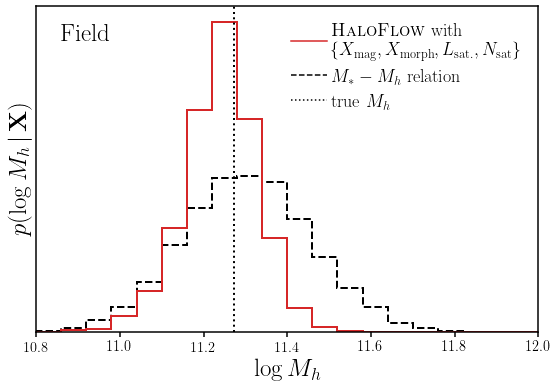

In [19]:
mcmc_mh_tng = logmh_tng(y_nde0[i_field,:,0])
mcmc_straw = np.array([y_nde0[i_field,:,0], np.array(mcmc_mh_tng)]).T

fig = plt.figure(figsize=(9,6))

sub = fig.add_subplot(111)
sub.hist(mcmc_straw[:,1], range=(10.8, 12), bins=20, histtype='step', color='k', linestyle='--', linewidth=2)
sub.hist(y_nde3[i_field][:,1], range=(10.8, 12), bins=20, histtype='step', color='C3', linestyle='-', linewidth=2)
sub.axvline(y0[i_field, 1], color='k', linestyle=':', linewidth=2)
sub.text(0.05, 0.95, 'Field', transform=sub.transAxes, ha='left', va='top', fontsize=25)

sub.plot([], [], color='C3', label=r'{\sc HaloFlow} with'+'\n'+r'$\{X_{\rm mag}, X_{\rm morph}, L_{\rm sat.}, N_{\rm sat}\}$')
sub.plot([], [], color='k', ls='--', label=r'$M_* - M_h$ relation')
sub.plot([], [], color='k', ls=':', label='true $M_h$')
sub.legend(loc='upper right', handletextpad=0.2, markerscale=5, fontsize=18)

sub.set_xlabel(r'$\log M_h$', fontsize=25)
sub.set_xlim((10.8, 12))
sub.set_ylabel(r'$p(\log M_h\,|\,{\bf X})$', fontsize=25)
sub.set_yticks([])

#fig.savefig('figs/posterior_mh_field_straw.pdf', bbox_inches='tight')

0.30671831176046815
0.16779674530029354
0.4586500974549814
0.31634292602539027


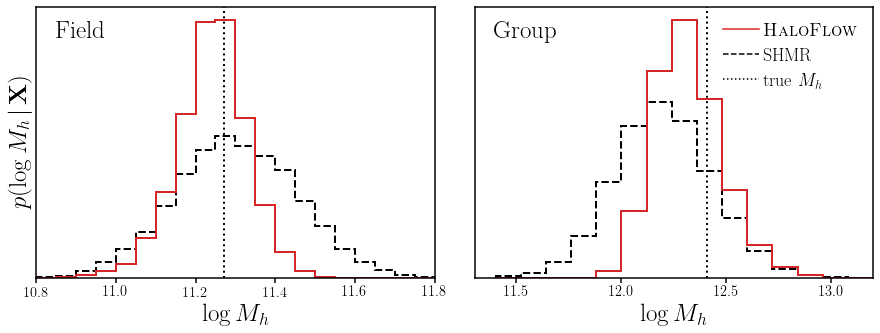

In [40]:
fig = plt.figure(figsize=(15,5))

mcmc_mh_tng = logmh_tng(y_nde0[i_field,:,0])
mcmc_straw = np.array([y_nde0[i_field,:,0], np.array(mcmc_mh_tng)]).T

sub = fig.add_subplot(121)
sub.hist(mcmc_straw[:,1], range=(10.8, 11.8), bins=20, histtype='step', color='k', linestyle='--', linewidth=2)
sub.hist(y_nde3[i_field][:,1], range=(10.8, 11.8), bins=20, histtype='step', color='C3', linestyle='-', linewidth=2)
sub.axvline(y0[i_field, 1], color='k', linestyle=':', linewidth=2)
sub.text(0.05, 0.95, 'Field', transform=sub.transAxes, ha='left', va='top', fontsize=25)


print(np.quantile(mcmc_straw[:,1], 0.84) - np.quantile(mcmc_straw[:,1], 0.16))
print(np.quantile(y_nde3[i_field][:,1], 0.84) - np.quantile(y_nde3[i_field][:,1], 0.16))
sub.set_xlabel(r'$\log M_h$', fontsize=25)
sub.set_xlim((10.8, 11.8))
sub.set_ylabel(r'$p(\log M_h\,|\,{\bf X})$', fontsize=25)
sub.set_yticks([])


mcmc_mh_tng = logmh_tng(y_nde0[i_group,:,0])
mcmc_straw = np.array([y_nde0[i_group,:,0], np.array(mcmc_mh_tng)]).T

sub = fig.add_subplot(122)
sub.hist(mcmc_straw[:,1], range=(11.4, 13.8), bins=20, histtype='step', color='k', linestyle='--', linewidth=2)
sub.hist(y_nde3[i_group][:,1], range=(11.4, 13.8), bins=20, histtype='step', color='C3', linestyle='-', linewidth=2)
sub.axvline(y0[i_group, 1], color='k', linestyle=':', linewidth=2)
sub.text(0.05, 0.95, 'Group', transform=sub.transAxes, ha='left', va='top', fontsize=25)

sub.plot([], [], color='C3', label=r'{\sc HaloFlow}')
sub.plot([], [], color='k', ls='--', label=r'SHMR')
sub.plot([], [], color='k', ls=':', label='true $M_h$')
sub.legend(loc='upper right', handletextpad=0.2, markerscale=5, fontsize=18)

print(np.quantile(mcmc_straw[:,1], 0.84) - np.quantile(mcmc_straw[:,1], 0.16))
print(np.quantile(y_nde3[i_group][:,1], 0.84) - np.quantile(y_nde3[i_group][:,1], 0.16))
sub.set_xlabel(r'$\log M_h$', fontsize=25)
sub.set_xlim((11.3, 13.2))
sub.set_xticks([11.5, 12., 12.5, 13.])
#sub.set_ylabel(r'$p(\log M_h\,|\,{\bf X})$', fontsize=25)
sub.set_yticks([])

#fig.savefig('figs/posterior_mh_field_straw.pdf', bbox_inches='tight')
fig.subplots_adjust(wspace=0.1)
fig.savefig('figs/posterior_mh_straw.pdf', bbox_inches='tight')

# overall performance

In [21]:
is_field = (x3[:,-1] == 0)
print('%.2f are fields' % np.mean(is_field))
is_group = (x3[:,-1] > 0)
print('%.2f are groups' % np.mean(is_group))

0.71 are fields
0.29 are groups


0.09533112525939957
0.07835565567016589
0.07781019210815465
0.0735013580322268

0.11526194572448745
0.10522408485412571
0.09562777519226051
0.09731009483337383


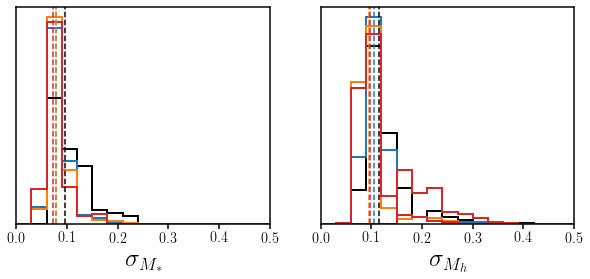

In [22]:
fig = plt.figure(figsize=(10,4))
sub = fig.add_subplot(121)
for y_nde, clr in zip([y_nde0, y_nde1, y_nde2, y_nde3], ['k', 'C0', 'C1', 'C3']): 
    q1, q2 = np.quantile(y_nde[is_field,:,0], (0.16, 0.84), axis=1)
    
    _ = sub.hist(0.5*(q2-q1), range=(0., 0.6), bins=20, histtype='step', linewidth=2, color=clr)
    print(np.median(0.5*(q2-q1)))
    sub.axvline(np.median(0.5*(q2-q1)), color=clr, linestyle='--')
sub.set_xlabel(r'$\sigma_{M_*}$', fontsize=25)
sub.set_xlim(0., 0.5)
sub.set_yticks([])

print()

sub = fig.add_subplot(122)
for y_nde, clr in zip([y_nde0, y_nde1, y_nde2, y_nde3], ['k', 'C0', 'C1', 'C3']): 
    q1, q2 = np.quantile(y_nde[is_field,:,1], (0.16, 0.84), axis=1)
    
    _ = sub.hist(0.5*(q2-q1), range=(0., 0.6), bins=20, histtype='step', linewidth=2, color=clr)
    print(np.median(0.5*(q2-q1)))
    sub.axvline(np.median(0.5*(q2-q1)), color=clr, linestyle='--')
sub.set_xlabel(r'$\sigma_{M_h}$', fontsize=25)
sub.set_xlim(0., 0.5)
sub.set_yticks([])

mcmcs_mh_tng = []
for y in y_nde0[is_group,:,0]: 
    mcmcs_mh_tng.append(logmh_tng(y))
q1, q2 = np.quantile(mcmcs_mh_tng, (0.16, 0.84), axis=1)    
_ = sub.hist(0.5*(q2-q1), range=(0., 0.6), bins=20, histtype='step', linewidth=2, color=clr)

fig.subplots_adjust(hspace=0.1)

0.06527667999267539 0.15055618352360195 0.26578725814819393
0.05184556961059528 0.10867283039622838 0.28237844467163065
0.07759006500244148 0.11810636507140264 0.28431423187255866
0.0753094863891608 0.10887337896558974 0.20824680328369105

0.078896865844726 0.1821533728970422 0.43922847747802773
0.07645746231079098 0.14916996558507284 0.4126966857910155
0.07689207077026339 0.13829582214355474 0.38492887496948214
0.0759075546264647 0.131816537645128 0.3357510185241699


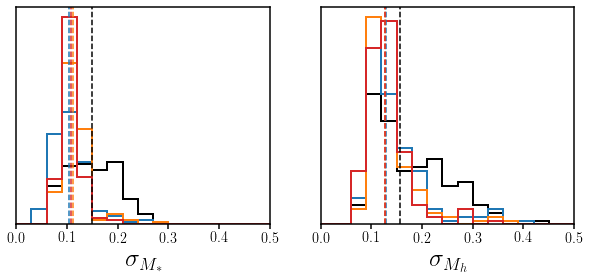

In [23]:
fig = plt.figure(figsize=(10,4))
sub = fig.add_subplot(121)
for y_nde, clr in zip([y_nde0, y_nde1, y_nde2, y_nde3], ['k', 'C0', 'C1', 'C3']): 
    q1, q2 = np.quantile(y_nde[is_group,:,0], (0.16, 0.84), axis=1)
    mcmc_straw = np.array([y_nde0[i_field,:,0], np.array(mcmc_mh_tng)]).T

    _ = sub.hist(0.5*(q2-q1), range=(0., 0.6), bins=20, histtype='step', linewidth=2, color=clr)
    print(np.min(0.5*(q2-q1)), np.mean(0.5*(q2-q1)), np.max(0.5*(q2-q1)))
    sub.axvline(np.median(0.5*(q2-q1)), color=clr, linestyle='--')
sub.set_xlabel(r'$\sigma_{M_*}$', fontsize=25)
sub.set_xlim(0., 0.5)
sub.set_yticks([])

print()

sub = fig.add_subplot(122)
for y_nde, clr in zip([y_nde0, y_nde1, y_nde2, y_nde3], ['k', 'C0', 'C1', 'C3']): 
    q1, q2 = np.quantile(y_nde[is_group,:,1], (0.16, 0.84), axis=1)
    
    _ = sub.hist(0.5*(q2-q1), range=(0., 0.6), bins=20, histtype='step', linewidth=2, color=clr)
    print(np.min(0.5*(q2-q1)), np.mean(0.5*(q2-q1)), np.max(0.5*(q2-q1)))
    sub.axvline(np.median(0.5*(q2-q1)), color=clr, linestyle='--')
sub.set_xlabel(r'$\sigma_{M_h}$', fontsize=25)
sub.set_xlim(0., 0.5)
sub.set_yticks([])

fig.subplots_adjust(hspace=0.1)

0.1523726573573132 0.2084683825019199 0.3540069620698496


[]

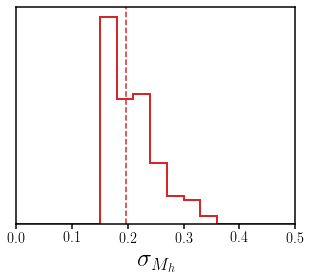

In [24]:
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(111)

logmhs = []
for _y in y_nde0[is_group,:,0]:
    logmhs.append(logmh_tng(_y))
q1, q2 = np.quantile(logmhs, (0.16, 0.84), axis=1)

_ = sub.hist(0.5*(q2-q1), range=(0., 0.6), bins=20, histtype='step', linewidth=2, color=clr)
print(np.min(0.5*(q2-q1)), np.mean(0.5*(q2-q1)), np.max(0.5*(q2-q1)))
sub.axvline(np.median(0.5*(q2-q1)), color=clr, linestyle='--')
sub.set_xlabel(r'$\sigma_{M_h}$', fontsize=25)
sub.set_xlim(0., 0.5)
sub.set_yticks([])

0.15034657028232612 0.17455178993402182 0.33659042245370774


[]

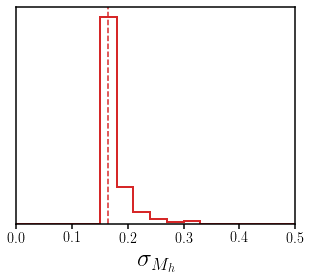

In [25]:
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(111)

logmhs = []
for _y in y_nde0[is_field,:,0]:
    logmhs.append(logmh_tng(_y))
q1, q2 = np.quantile(logmhs, (0.16, 0.84), axis=1)

_ = sub.hist(0.5*(q2-q1), range=(0., 0.6), bins=20, histtype='step', linewidth=2, color=clr)
print(np.min(0.5*(q2-q1)), np.mean(0.5*(q2-q1)), np.max(0.5*(q2-q1)))
sub.axvline(np.median(0.5*(q2-q1)), color=clr, linestyle='--')
sub.set_xlabel(r'$\sigma_{M_h}$', fontsize=25)
sub.set_xlim(0., 0.5)
sub.set_yticks([])

In [95]:
def msmh_moster(logMh, A, beta, gamma, M1): 
    Mh = 10**logMh
    return 2. * A * ((Mh/M1)**-beta + (Mh/M1)**gamma)**-1

def mh_moster(logMs, A, beta, gamma, M1):
    mh_arr = np.linspace(10., 15., 201)
    ms_arr = 10**mh_arr * msmh_moster(mh_arr, A, beta, gamma, M1)
    return np.interp(logMs, np.log10(ms_arr), mh_arr)
    
def moster_posterior(): 
    A = 0.02820 + 0.00057*np.random.normal()
    beta = 1.057 + 0.05*np.random.normal()
    gamma = 0.556 + 0.07*np.random.normal()
    M1 = 10**(11.884 + 0.0265*np.random.normal())
    return A, beta, gamma, M1

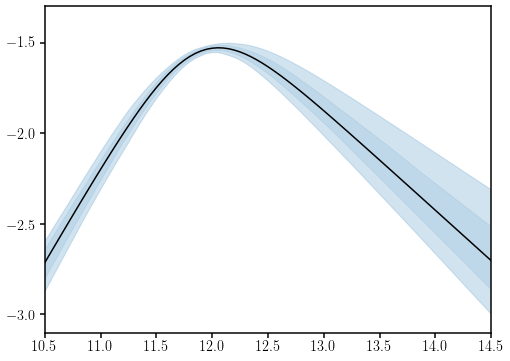

In [71]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

logMhs = np.linspace(10, 15, 101)


msmhs = []
for i in range(100): 
    theta = moster_posterior()
    msmhs.append(np.log10(msmh_moster(logMhs, *theta)))
sub.fill_between(logMhs, np.quantile(msmhs, 0.16, axis=0), np.quantile(msmhs, 0.84, axis=0), color='C0', alpha=0.1)
sub.fill_between(logMhs, np.quantile(msmhs, 0.025, axis=0), np.quantile(msmhs, 0.975, axis=0), color='C0', alpha=0.2)
sub.plot(logMhs, np.log10(msmh_moster(logMhs, 0.02820, 1.057, 0.556, 10**11.884)), c='k')
sub.set_xlim(10.5, 14.5)
sub.set_ylim(-3.1, -1.3)
sub.set_yticks([-3.0, -2.5, -2., -1.5])

In [100]:
mh_straw = []
for ms in y_nde0[i_group,:,0]:
    theta = moster_posterior()
    mh_straw.append(mh_moster(ms, *theta))
    
mcmc_straw = np.array([y_nde0[i_group,:,0], np.array(mh_straw)]).T

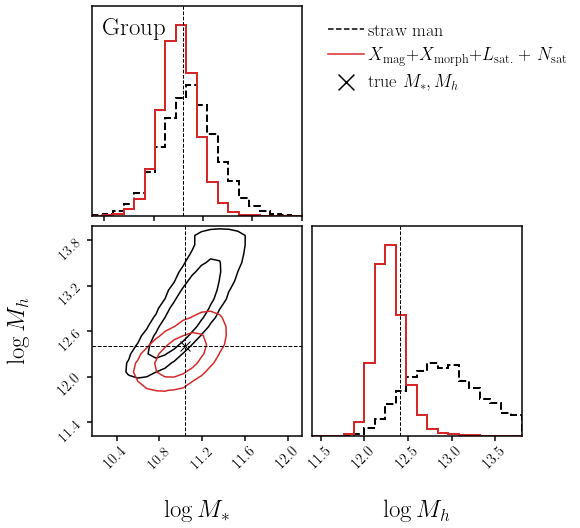

In [104]:
fig = plt.figure(figsize=(8,8))

rng = [(10.3, 12.0), (11.4, 13.8)]
_ = DFM.corner(mcmc_straw, color='k', range=rng, 
                 hist_kwargs={'density': True, 'linewidth': 2, 'linestyle':'--'},
                 levels=[0.68, 0.95], plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
_ = DFM.corner(y_nde3[i_group], color='C3', range=rng, hist_kwargs={'density': True, 'linewidth': 2},
               levels=[0.68, 0.95], 
               labels=[r'$\log M_*$', r'$\log M_h$'], label_kwargs={'fontsize': 25},
                plot_datapoints=False, plot_density=False, smooth=True, fig=fig)
DFM.overplot_points(fig, [y0[i_group]], color='k', marker='x', markersize=10)
DFM.overplot_lines(fig, y0[i_group], color='k', linestyle='--', linewidth=1)

axes = np.array(fig.axes).reshape(2,2)

sub = axes[0,0]
sub.text(0.05, 0.95, 'Group', transform=sub.transAxes, ha='left', va='top', fontsize=25)

sub = axes[0,1]
sub.plot([], [], color='k', ls='--', label=r'straw man')
sub.plot([], [], color='C3', label=r'$X_{\rm mag}$+$X_{\rm morph}$'+r'+$L_{\rm sat.}$ + $N_{\rm sat}$')
sub.scatter([], [], color='k', marker='x', s=10, label='true $M_*, M_h$')
sub.legend(loc='upper left', handletextpad=0.2, markerscale=5, fontsize=18)

sub = axes[1,1]
sub.set_xlim(rng[1])


sub = axes[0,0]
sub.set_xlim(rng[0])
fig.savefig('figs/posterior_group_straw.pdf', bbox_inches='tight')

(9.5, 12.0)

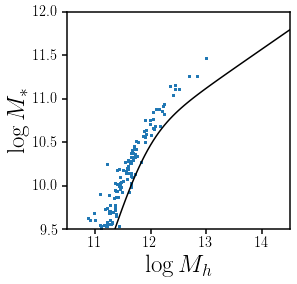

In [112]:
fig = plt.figure(figsize=(4,4))
sub = fig.add_subplot(111)

logMhs = np.linspace(10, 15, 101)

sub.plot(logMhs, logMhs + np.log10(msmh_moster(logMhs, 0.02820, 1.057, 0.556, 10**11.884)), c='k')
sub.scatter(y0[:,1], y0[:,0], s=4)
sub.set_xlabel(r'$\log M_h$', fontsize=25)
sub.set_xlim(10.5, 14.5)
sub.set_ylabel(r'$\log M_*$', fontsize=25)
sub.set_ylim(9.5, 12.)